# 第6章 支持向量机

本章内容：
- 简单介绍支持向量机
- 利用SMO进行优化
- 利用核函数对数据进行空间转换
- 将SVM和其他分类器进行对比

## 6.1 基于最大间隔分隔数据

<center>**支持向量机**</center>
- 优点：泛化错误率低，计算开销不大，结果易解释。
- 缺点：对参数调节和核函数的选择敏感，原始分类器不加修改仅适用于处理二类问题。
- 使用数据类型：数值型和标称型数据。

线性可分（linearly separable）数据
分隔超平面（separating hyperplane）
间隔（margin）
支持向量（support vector）

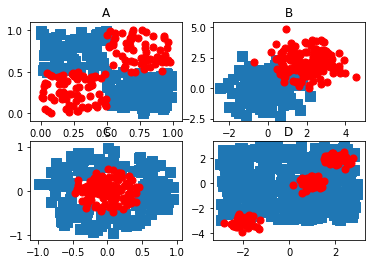

In [2]:
from numpy import *
import matplotlib
import matplotlib.pyplot as plt

xcord0 = []; ycord0 = []; xcord1 = []; ycord1 = []
markers =[]
colors =[]
fr = open('./Data/testSet.txt')#this file was generated by 2normalGen.py
for line in fr.readlines():
    lineSplit = line.strip().split('\t')
    xPt = float(lineSplit[0])
    yPt = float(lineSplit[1])
    label = int(lineSplit[2])
    if (label == 0):
        xcord0.append(xPt)
        ycord0.append(yPt)
    else:
        xcord1.append(xPt)
        ycord1.append(yPt)

fr.close()
fig = plt.figure()
ax = fig.add_subplot(221)
xcord0 = []; ycord0 = []; xcord1 = []; ycord1 = []
for i in range(300):
    [x,y] = random.uniform(0,1,2)
    if ((x > 0.5) and (y < 0.5)) or ((x < 0.5) and (y > 0.5)):
        xcord0.append(x); ycord0.append(y)
    else:
        xcord1.append(x); ycord1.append(y)
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('A')
ax = fig.add_subplot(222)
xcord0 = random.standard_normal(150); ycord0 = random.standard_normal(150)
xcord1 = random.standard_normal(150)+2.0; ycord1 = random.standard_normal(150)+2.0
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('B')
ax = fig.add_subplot(223)
xcord0 = []; ycord0 = []; xcord1 = []; ycord1 = []
for i in range(300):
    [x,y] = random.uniform(0,1,2)
    if (x > 0.5):
        xcord0.append(x*cos(2.0*pi*y)); ycord0.append(x*sin(2.0*pi*y))
    else:
        xcord1.append(x*cos(2.0*pi*y)); ycord1.append(x*sin(2.0*pi*y))
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('C')
ax = fig.add_subplot(224)
xcord1 = zeros(150); ycord1 = zeros(150)
xcord0 = random.uniform(-3,3,350); ycord0 = random.uniform(-3,3,350);
xcord1[0:50] = 0.3*random.standard_normal(50)+2.0; ycord1[0:50] = 0.3*random.standard_normal(50)+2.0

xcord1[50:100] = 0.3*random.standard_normal(50)-2.0; ycord1[50:100] = 0.3*random.standard_normal(50)-3.0

xcord1[100:150] = 0.3*random.standard_normal(50)+1.0; ycord1[100:150] = 0.3*random.standard_normal(50)
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('D')
plt.show()

## 6.2 寻找最大间隔

#### 6.2.1 分类器求解的优化问题

$$arg max_{w,b}\{min_{n}(label*(w^{T}x+b))*\frac{1}{||w||}\}$$

$$max_{\alpha}\left[\sum_{i=1}^{m}\alpha - \frac{1}{2}\sum_{i,j=1}^{m}label^{(i)}*label^{(j)}*a_i*a_j<x^{(i)},x^{(j)}>\right]$$

其约束条件为：

$$\alpha\ge 0, and \sum_{i=1}^{m}\alpha_{i}\cdot label^{(i)}=0$$

In [ ]:
6.2.2 SVM应用的一般框架

<center>**SVM的一般流程**</center>
1. 收集数据：可以使用任意方法。
2. 准备数据：需要数值型数据。
3. 分析数据：有助于可视化分隔超平面。
4. 训练算法：SVM的大部分时间都源自训练，该过程主要实现两个参数的调优。
5. 测试算法：十分简单的计算过程就可以实现。
6. 使用算法：几乎所有分类问题都可以使用SVM，值得一提的是，SVM本身是一个二类分类器，对多类问题应用SVM需要对代码做一些修改。

## 6.3 SMO高效优化算法

#### 6.3.1 Platt的SMO算法

SMO算法的工作原理是：每次循环中选择两个alpha进行优化处理。一旦找到一对合适的alpha，那么就增大其中一个同时减小另一个。这里所谓的“合适”就是指两个alpha必须要符合一定的条件，条件之一就是这两个alpha必须要在间隔边界之外，而其第二个条件则是这两个alpha还没有进行过区间化处理或者不在边界上。

#### 6.3.2 应用简化版SMO算法处理小规模数据集

###### 程序清单6-1 SMO算法中的辅助函数

In [28]:
def loadDataSet(fileName):
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def selectJrand(i,m):
    j = i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

In [29]:
dataArr, labelArr = loadDataSet('./Data/testSet.txt')
labelArr

[-1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0]

**SMO函数的伪代码大致如下：**  

创建一个alpha向量并将其初始化为0向量  
当迭代次数小于最大迭代次数时（外循环）  
　　对数据集中的每个数据向量（内循环）：  
　　　　如果该数据向量可以被优化：  
   　　　　随机选择另外一个数据向量  
       　同时优化这两个向量  
       　如果两个向量都不能被优化，退出内循环  
   如果所有向量都没被优化，增加迭代数目，继续下一次循环     

###### 程序清单6-2 简化版SMO算法

In [ ]:
import numpy as np

def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = np.mat(dataMatIn)
    labelMat = np.mat(classLabels).transpose()
    b = 0
    m, n = np.shape(dataMatrix)
    alphas = np.mat(np.zeros([m, 1]))
    iter = 0
    while (iter<maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float(multiply(alphas, labelMat).T * (dataMatrix * dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])
            if ((labelMat[i] * Ei < -toler) and )